### set another directory for unsupervised analysis

In [172]:
cd ~/Desktop/SSUsearch/

/home/gjr/Desktop/SSUsearch


In [173]:
mkdir -p ./workdir/clust

In [174]:
Prefix='SS'    # name for the analysis run
Script_dir='./scripts'
Wkdir='./workdir'
Mcclust_jar='./external_tools/Clustering/dist/Clustering.jar'
Java_xmx='1g'
Java_gc_threads='2'
Otu_dist_cutoff='0.05'
Design='./data/test/SS.design'


In [175]:
# get absolute path
import os
Script_dir=os.path.abspath(Script_dir)
Wkdir=os.path.abspath(Wkdir)
Mcclust_jar=os.path.abspath(Mcclust_jar)
Design=os.path.abspath(Design)
New_path = '{}:{}'.format('~/Desktop/SSUsearch/external_tools/bin/', os.environ['PATH'])

print New_path
print Mcclust_jar

os.environ.update(
    {'PATH':New_path,
     'Prefix':Prefix, 
     'Script_dir': Script_dir, 
     'Wkdir': Wkdir, 
     'Mcclust_jar': Mcclust_jar, 
     'Java_xmx':Java_xmx, 
     'Java_gc_threads':Java_gc_threads, 
     'Otu_dist_cutoff':Otu_dist_cutoff, 
     'Design': Design})

~/Desktop/SSUsearch/external_tools/bin/:~/Desktop/SSUsearch/external_tools/bin/:~/Desktop/SSUsearch/external_tools/bin/:~/Desktop/SSUsearch/external_tools/bin/:~/Desktop/SSUsearch/external_tools/bin/:/home/gjr/anaconda/bin:/usr/lib/lightdm/lightdm:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games
/home/gjr/Desktop/SSUsearch/external_tools/Clustering/dist/Clustering.jar


In [176]:
cd ./workdir/clust

/home/gjr/Desktop/SSUsearch/workdir/clust


In [177]:
!sed -i 's/:/_/g' $Wkdir/*.ssu.out/*.forclust
!echo "*** Replace ':' with '_' in seq names (original illumina name has ':' in them)"

*** Replace ':' with '_' in seq names (original illumina name has ':' in them)


In [178]:
cat $Wkdir/*.ssu.out/*.forclust > combined_seqs.afa

In [179]:
# make group file for mcclust and mothur. 
# first part of the file basename will be the group label, e.g. file "aa.bb.cc" will have "aa" as group label.
!python $Script_dir/make-groupfile.py $Prefix.groups $Wkdir/*.ssu.out/*.forclust

input is list of files..


In [180]:
!echo "*** Starting mcclust derep"
!time java -Xmx$Java_xmx -XX:+UseParallelOldGC -XX:ParallelGCThreads=$Java_gc_threads \
    -jar $Mcclust_jar derep -a -o derep.fasta \
    temp.mcclust.names temp.txt combined_seqs.afa
    
!rm temp.txt

*** Starting mcclust derep
Processing combined_seqs.afa
Total sequences: 113
Unique sequences: 105
Dereplication complete: 585
1.11user 0.12system 0:00.88elapsed 139%CPU (0avgtext+0avgdata 151920maxresident)k
0inputs+144outputs (0major+9689minor)pagefaults 0swaps


In [181]:
# convert mcclust names to mothur names
!python $Script_dir/mcclust2mothur_names_file.py temp.mcclust.names temp.mothur.names

In [182]:
%%bash

echo "starting preclust.."
### output: derep.precluster.fasta, derep.precluster.names
mothur "#pre.cluster(fasta=derep.fasta, diffs=1, name=temp.mothur.names)"

starting preclust..






mothur v.1.33.3
Last updated: 4/4/2014

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > pre.cluster(fasta=derep.fasta, diffs=1, name=temp.mothur.names)

Using 1 processors.
0	105	0
100	100	5
105	100	5
Total number of sequences before precluster was 105.
pre.cluster removed 5 sequences.

It took 0 secs to cluster 105 sequences.

Output File Names: 
derep.precluster.fasta
derep.precluster.names
derep.precluster.map


mothur > quit()


In [183]:
!python $Script_dir/mothur2mcclust_names_file.py derep.precluster.names $Prefix.names

In [184]:
!time java -Xmx$Java_xmx -XX:+UseParallelOldGC -XX:ParallelGCThreads=$Java_gc_threads \
    -jar $Mcclust_jar dmatrix \
    -l 25 -o matrix.bin -i $Prefix.names -I derep.precluster.fasta

Reading sequences(memratio=0.0013223222178831366)...
Using distance model edu.msu.cme.rdp.alignment.pairwise.rna.UncorrectedDistanceModel
Read 100 Nucleotide sequences (memratio=0.002375283433787936)
Reading ID Mapping from file /home/gjr/Desktop/SSUsearch/workdir/clust/SS.names
Read mapping for 113 sequences (memratio=0.00263591914083957)
Starting distance computations, predicted max edges=10000, at=Sun Oct 25 12:07:35 EDT 2015
Dumping 4950 edges to partial_matrix0 FINAL EDGES (memory ratio=0.006928596611829683)
Matrix edges computed: 196
Maximum distance: 0.5750000000000001
Splits: 1
Partition files merged: 17
0.68user 0.07system 0:00.66elapsed 114%CPU (0avgtext+0avgdata 104720maxresident)k
0inputs+184outputs (0major+6739minor)pagefaults 0swaps


In [185]:
!time java -Xmx$Java_xmx -XX:+UseParallelOldGC -XX:ParallelGCThreads=$Java_gc_threads \
    -jar $Mcclust_jar cluster -m upgma \
    -i $Prefix.names -s $Prefix.groups -o complete.clust -d matrix.bin

!python $Script_dir/mcclust2mothur-list-cutoff.py complete.clust $Prefix.list $Otu_dist_cutoff

lambda=0
Clustering complete: 634
Lookaheads performed: 0
Time spent Looking ahead: 0
1.44user 0.10system 0:00.96elapsed 161%CPU (0avgtext+0avgdata 116896maxresident)k
0inputs+456outputs (0major+7759minor)pagefaults 0swaps
File(s):	1c 1d 2c 2d 

Sequences:	28 26 33 26 



In [186]:
!java -jar $Mcclust_jar rep-seqs -c -l -s complete.clust $Otu_dist_cutoff combined_seqs.afa
!mv complete.clust_rep_seqs.fasta otu_rep_align.fa

In [187]:
%%bash

mothur "#make.shared(list=$Prefix.list, group=$Prefix.groups, label=$Otu_dist_cutoff);"
cat $Wkdir/*.ssu.out/*.silva.taxonomy > $Prefix.taxonomy
mothur "#classify.otu(list=$Prefix.list, taxonomy=$Prefix.taxonomy, label=$Otu_dist_cutoff)"
mothur "#make.biom(shared=$Prefix.shared, constaxonomy=$Prefix.$Otu_dist_cutoff.cons.taxonomy)"
mv $Prefix.$Otu_dist_cutoff.biom $Prefix.biom







mothur v.1.33.3
Last updated: 4/4/2014

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > make.shared(list=SS.list, group=SS.groups, label=0.05)
0.05

Output File Names: 
SS.shared
SS.1c.rabund
SS.1d.rabund
SS.2c.rabund
SS.2d.rabund


mothur > quit()






mothur v.1.33.3
Last updated: 4/4/2014

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent,

In [188]:
# clean up tempfiles
!rm -f mothur.*.logfile *rabund complete* derep.fasta matrix.bin nonoverlapping.bin temp.*

### With SS.groups, SS.names and SS.list, most diversity analysis can be done by mothur. You can look at [mothur wiki](http://www.mothur.org/wiki/454_SOP) for details (Do not forgot to do even sampling before beta-diversity analysis).

### SS.biom file can used in most tools. (qiime and rdp)



In [189]:
%%bash

#since The purpose of this tutorial is to show our new pipeline, we will skip details of community analysis with mothur
#following are some common commands in mothur

# mothur is inconsistent with the "Label" in files names. I have seens either "dummy" or "useLabel“
# "dummy" for 1.33.3; "userLabel" for 1.34.4
Label=userLabel
#Label=dummy

mothur "#make.shared(biom=$Prefix.biom); sub.sample(shared=$Prefix.shared); summary.single(calc=nseqs-coverage-sobs-chao-shannon-invsimpson); dist.shared(calc=braycurtis); pcoa(phylip=$Prefix.$Label.subsample.braycurtis.$Label.lt.dist); nmds(phylip=$Prefix.$Label.subsample.braycurtis.$Label.lt.dist); amova(phylip=$Prefix.$Label.subsample.braycurtis.$Label.lt.dist, design=$Design); tree.shared(calc=braycurtis); unifrac.weighted(tree=$Prefix.$Label.subsample.braycurtis.$Label.tre, group=$Design, random=T)"
rm -f mothur.*.logfile; 
rm -f *.rabund







mothur v.1.33.3
Last updated: 4/4/2014

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
pschloss@umich.edu
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

Type 'quit()' to exit program



mothur > make.shared(biom=SS.biom)

dummy

Output File Names: 
SS.shared
SS.1c.rabund
SS.1d.rabund
SS.2c.rabund
SS.2d.rabund


mothur > sub.sample(shared=SS.shared)
Sampling 26 from each group.
dummy

Output File Names: 
SS.dummy.subsample.shared


mothur > summary.single(calc=nseqs-coverage-sobs-chao-shannon-invsimpson)
Using SS.dummy.subsample.shared as input file for the shared parameter.

Processing group 1c

dummy

Processing group 1d

d

In [190]:
!echo "This part of pipeline finishes successfully :)"

This part of pipeline finishes successfully :)


In [191]:
### some simple visualization

In [198]:
%%bash

Label=userLabel
#Label=dummy

# alpha diveristy index
python $Script_dir/plot-diversity-index.py $Label "chao,shannon,invsimpson" "c,d" "SS.$Label.subsample.groups.summary" "test" "test.alpha" 

2 samples collect for Kw c
2 samples collect for Kw d
2 samples collect for Kw c
2 samples collect for Kw d
2 samples collect for Kw c
2 samples collect for Kw d


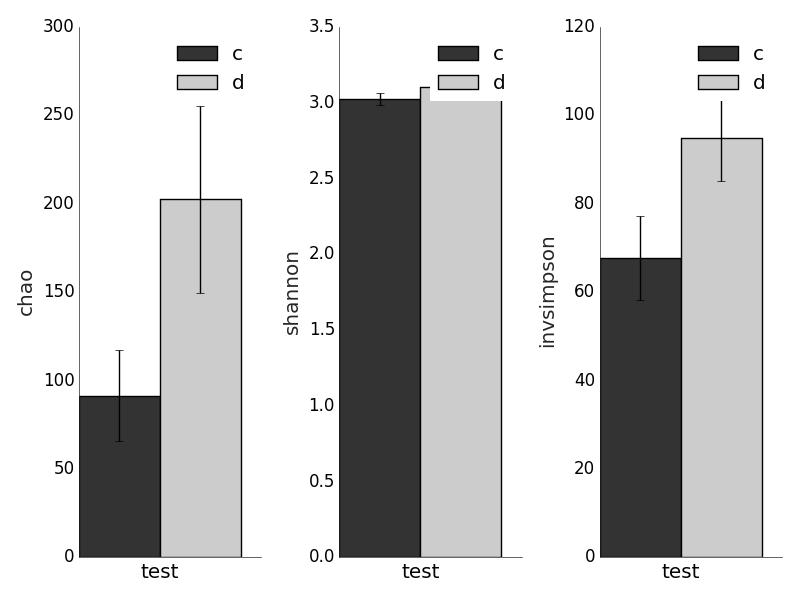

In [199]:
from IPython.display import Image
Image('test.alpha.png')

In [200]:
# taxon distribution
!python $Script_dir/plot-taxa-count.py 2 test.taxa.dist ../*.ssu.out/*.silva.taxonomy.count

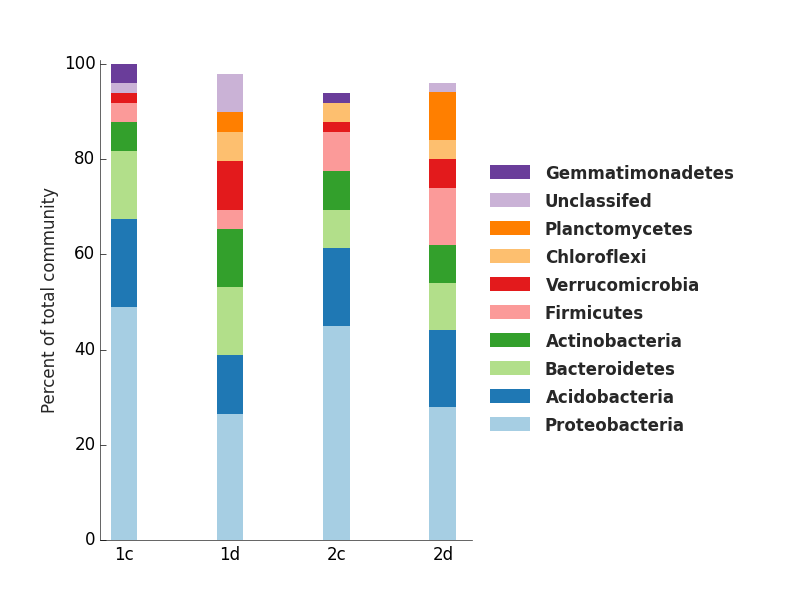

In [195]:
from IPython.display import Image
Image('test.taxa.dist.png')

In [203]:
%%bash

Label=userLabel
#Label=dummy

# ordination
python $Script_dir/plot-pcoa.py  SS.$Label.subsample.braycurtis.$Label.lt.pcoa.axes  SS.$Label.subsample.braycurtis.$Label.lt.pcoa.loadings  test.beta.pcoa

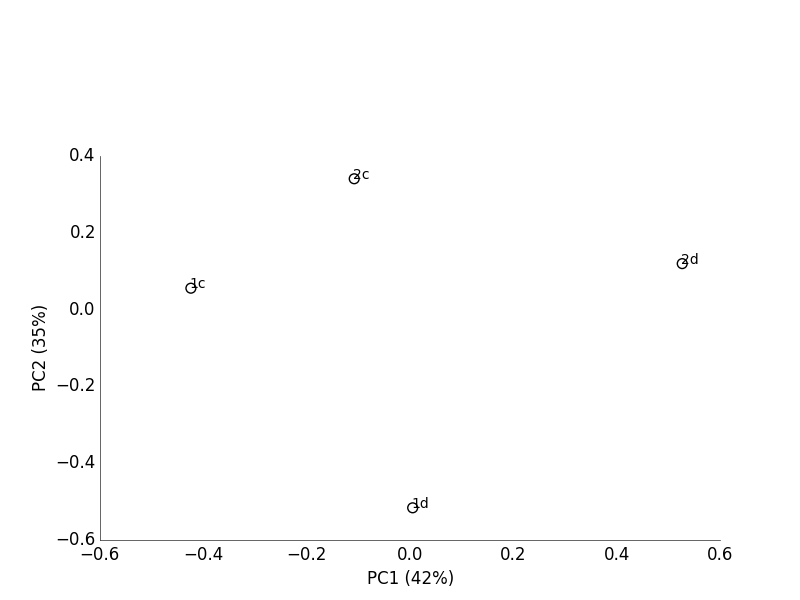

In [204]:
from IPython.display import Image
Image('test.beta.pcoa.png')